In [3]:
import ccxt
import pandas as pd
import ta
import requests
from datetime import datetime, timedelta

In [4]:
def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [5]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

def add_indicators(df):
    # Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

    df_ind = df.copy()

    df_ind['rsi'] = RSI(df_ind['close']).rsi()
    df_ind['macd'] = MACD(df_ind['close']).macd()
    df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
    df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
    df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
    df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
    df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
    df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
    df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
    df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
    df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

    return df_ind

In [7]:
btc = symbol_data(symbol='BTC/USDT')
xrp = symbol_data(symbol='XRP/USDT')
sol = symbol_data()
doge = symbol_data(symbol='DOGE/USDT')
eth = symbol_data(symbol='ETH/USDT')

In [8]:
btc['symbol'] = 'btc'
xrp['symbol'] = 'xrp'
sol['symbol'] = 'sol'
doge['symbol'] = 'doge'
eth['symbol'] = 'eth'

In [57]:
btc_full = add_indicators(btc)
xrp_full = add_indicators(xrp)
sol_full = add_indicators(sol)
doge_full = add_indicators(doge)
eth_full = add_indicators(eth)

In [80]:
btc_full = btc_full.dropna()
xrp_full = xrp_full.dropna()
sol_full = sol_full.dropna()
doge_full = doge_full.dropna()
eth_full = eth_full.dropna()

In [67]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Eliminar valores nulos
btc_full.dropna(inplace=True)

# Seleccionar las características de interés
features = ['rsi', 'macd', 'adx', 'adp', 'adm', 'dri', 'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']
X = btc_full[features]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para clustering
n_clusters = 3  # Definir el número de clústeres (por ejemplo, 3: compra, venta, hold)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
btc_full['cluster'] = kmeans.fit_predict(X_scaled)

# Interpretación de los clusters:
# Vamos a definir las señales de trading según los clusters. 
# Este es un ejemplo simple, pero puedes ajustar según el comportamiento de los datos.
btc_full['buy_signal'] = btc_full['cluster'].apply(lambda x: 1 if x == 0 else 0)  # Asignamos 'compra' al cluster 0
btc_full['sell_signal'] = btc_full['cluster'].apply(lambda x: 1 if x == 1 else 0)  # Asignamos 'venta' al cluster 1
btc_full['hold_signal'] = btc_full['cluster'].apply(lambda x: 1 if x == 2 else 0)  # Asignamos 'hold' al cluster 2

# Revisar los primeros valores para ver las señales generadas
print(btc_full[['date', 'close', 'buy_signal', 'sell_signal', 'hold_signal']].head(20))

# Guardar el dataset con las etiquetas generadas
btc_full.to_csv("crypto_labeled_signals.csv", index=False)


         date     close  buy_signal  sell_signal  hold_signal
25 2022-08-06  22951.20           1            0            0
26 2022-08-07  23177.58           1            0            0
27 2022-08-08  23815.45           0            0            1
28 2022-08-09  23150.39           1            0            0
29 2022-08-10  23952.14           0            0            1
30 2022-08-11  23935.04           0            0            1
31 2022-08-12  24395.19           0            0            1
32 2022-08-13  24437.66           0            0            1
33 2022-08-14  24303.56           0            0            1
34 2022-08-15  24095.41           1            0            0
35 2022-08-16  23859.05           1            0            0
36 2022-08-17  23335.92           1            0            0
37 2022-08-18  23187.30           1            0            0
38 2022-08-19  20827.96           1            0            0
39 2022-08-20  21137.82           1            0            0
40 2022-

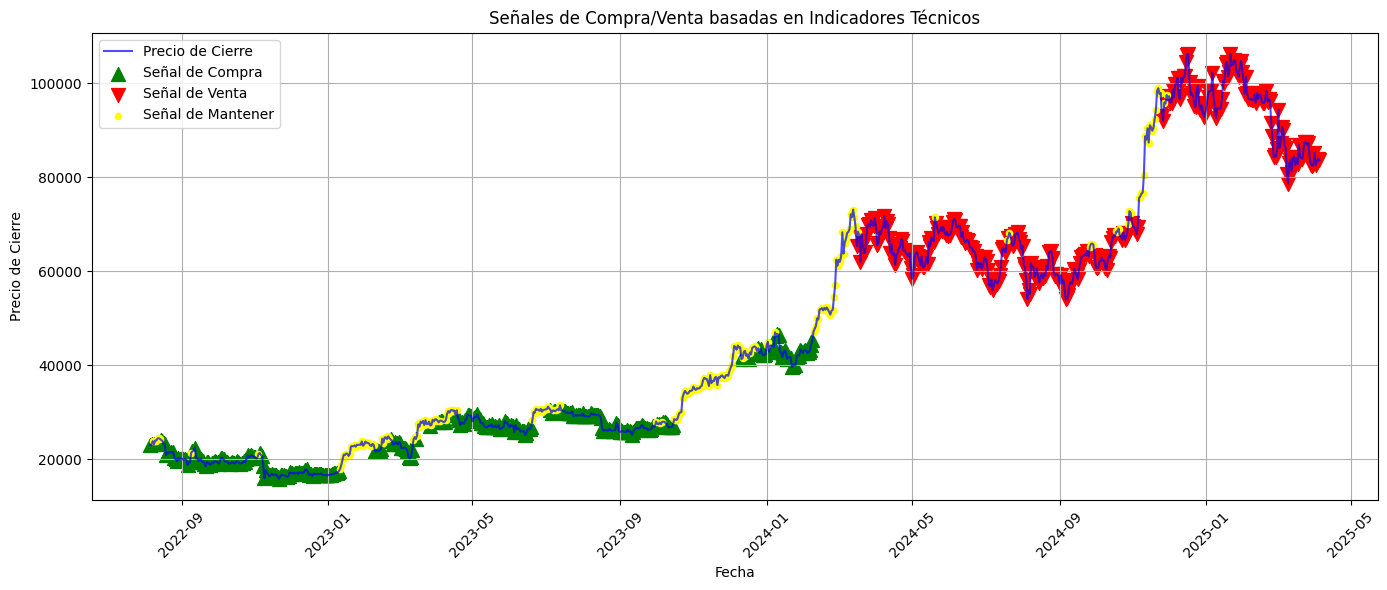

In [68]:
# Graficar las señales de compra/venta
plt.figure(figsize=(14, 6))
plt.plot(btc_full['date'], btc_full['close'], label='Precio de Cierre', color='blue', alpha=0.7)

# Señales de compra
plt.scatter(btc_full['date'][btc_full['buy_signal'] == 1], 
            btc_full.loc[btc_full['buy_signal'] == 1, 'close'],
            marker='^', color='green', label='Señal de Compra', s=100)

# Señales de venta
plt.scatter(btc_full['date'][btc_full['sell_signal'] == 1], 
            btc_full.loc[btc_full['sell_signal'] == 1, 'close'],
            marker='v', color='red', label='Señal de Venta', s=100)

# Señales de mantener
plt.scatter(btc_full['date'][btc_full['hold_signal'] == 1], 
            btc_full.loc[btc_full['hold_signal'] == 1, 'close'],
            marker='o', color='yellow', label='Señal de Mantener', s=20)

plt.title("Señales de Compra/Venta basadas en Indicadores Técnicos")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Para mejorar la legibilidad de las fechas
plt.tight_layout()  # Ajustar el diseño para que no se sobrepongan las etiquetas
plt.show()

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

def simular_portafolio(df, 
                       col_fecha='date', 
                       col_precio='open', 
                       col_compra='buy_signal', 
                       col_venta='sell_signal', 
                       capital_inicial=1000):
    """
    Simula una estrategia de trading basada en señales binarias de compra y venta.
    
    Parámetros:
    - df: DataFrame que contiene las señales y precios
    - col_fecha: Nombre de la columna de fechas
    - col_precio: Columna con precios de entrada/salida (ej. 'open')
    - col_compra: Columna con señales de compra (1 = comprar)
    - col_venta: Columna con señales de venta (1 = vender)
    - capital_inicial: Monto inicial del portafolio

    Retorna:
    - DataFrame con evolución del capital
    """
    # Inicializar variables
    capital = capital_inicial
    buy_price = 0
    holding = False

    # Listas para resultados
    capital_history = []
    buy_prices = []
    sell_prices = []

    for index, row in df.iterrows():
        # Señal de compra
        if row[col_compra] == 1 and not holding:
            buy_price = row[col_precio]
            holding = True
            buy_prices.append(buy_price)
            print(f"Compra a {buy_price} en {row[col_fecha]}")
        
        # Señal de venta
        elif row[col_venta] == 1 and holding:
            sell_price = row[col_precio]
            roi = (sell_price - buy_price) / buy_price
            capital += capital_inicial * roi
            sell_prices.append(sell_price)
            holding = False
            print(f"Venta a {sell_price} en {row[col_fecha]} | ROI: {roi*100:.2f}%")
        
        capital_history.append(capital)

    # Resultado final
    print(f"\n💰 Capital final: {capital:.2f} USDT")

    # DataFrame del historial
    df_capital = pd.DataFrame({
        'Date': df[col_fecha].values,
        'Capital': capital_history
    })

    # Visualización
    plt.figure(figsize=(14, 8))
    plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
    plt.title('📈 Evolución del Capital en el Portafolio con Señales', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Capital (USDT)', fontsize=12)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_capital


In [81]:
df = pd.concat([btc_full,xrp_full,sol_full,doge_full,eth_full])

In [82]:
df.to_csv('datos_dummies_2.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice
import random
import gym
from gym import spaces

# 2. Crear el entorno de gym para trading
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        
        self.df = df
        self.n_steps = len(df)
        self.current_step = 0
        
        # Espacios de acción: 0 -> hold, 1 -> buy, 2 -> sell
        self.action_space = spaces.Discrete(3)
        
        # Espacio de observación: 10 indicadores (como número de características)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32)
        
        # Inicializar la primera observación
        self.reset()

    def reset(self):
        self.current_step = 0
        return self.get_observation()

    def get_observation(self):
        features = self.df.iloc[self.current_step][['rsi', 'macd', 'adx', 'adp', 'adm', 'dri', 'dlogri', 'avgtr', 'donch_hband', 'vwap']].values
        return np.array(features, dtype=np.float32)
    
    def step(self, action):
        current_price = self.df.iloc[self.current_step]['close']
        done = False
        reward = 0

        if action == 1:  # Buy
            # Compra en el precio actual, calculamos la ganancia si vendemos en el futuro
            for future_step in range(self.current_step + 1, self.n_steps):
                future_price = self.df.iloc[future_step]['close']
                if future_price >= current_price * 1.05:  # Si sube más del 5%
                    reward = (future_price - current_price) / current_price  # Ganancia porcentual
                    break

        elif action == 2:  # Sell
            # Similar a la venta, podemos calcular la recompensa si el precio baja
            for future_step in range(self.current_step + 1, self.n_steps):
                future_price = self.df.iloc[future_step]['close']
                if future_price <= current_price * 0.95:  # Si baja más del 5%
                    reward = (current_price - future_price) / current_price  # Ganancia porcentual
                    break

        # Si no hay acción de compra o venta, recompensamos con 0 (hold)
        if action == 0:
            reward = 0

        self.current_step += 1

        # Si llegamos al final de los datos, terminamos el episodio
        if self.current_step == self.n_steps - 1:
            done = True
        
        return self.get_observation(), reward, done, {}

# 3. Construir el modelo de Deep Q-Learning (DQN)
class DQNAgent:
    def __init__(self, action_space, observation_space):
        self.action_space = action_space
        self.observation_space = observation_space
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, input_dim=self.observation_space.shape[0], activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_space.n, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        return model

    def act(self, state):
        state = np.expand_dims(state, axis=0)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch):
        if len(batch) < 32:
            return

        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        q_values = self.model.predict(states)
        next_q_values = self.model.predict(next_states)

        for i in range(len(batch)):
            if dones[i]:
                q_values[i][actions[i]] = rewards[i]
            else:
                q_values[i][actions[i]] = rewards[i] + 0.99 * np.max(next_q_values[i])

        self.model.fit(states, q_values, epochs=1, verbose=0)

# 4. Entrenar el modelo de Deep Q-Learning
def train_model(df):
    env = TradingEnv(df)
    agent = DQNAgent(env.action_space, env.observation_space)
    
    episodes = 1000
    batch_size = 32
    memory = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            memory.append((state, action, reward, next_state, done))
            
            if len(memory) > batch_size:
                agent.replay(memory)
                memory = memory[-batch_size:]

            state = next_state
            total_reward += reward

        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return agent

# 5. Uso del modelo entrenado para hacer predicciones en los datos
def make_predictions(agent, df):
    env = TradingEnv(df)
    state = env.reset()
    predictions = []

    while True:
        action = agent.act(state)
        predictions.append(action)
        next_state, _, done, _ = env.step(action)
        state = next_state
        if done:
            break
    
    df['predicted_action'] = predictions
    df['buy_signal'] = df['predicted_action'].apply(lambda x: 1 if x == 1 else 0)
    df['sell_signal'] = df['predicted_action'].apply(lambda x: 1 if x == 2 else 0)
    df['hold_signal'] = df['predicted_action'].apply(lambda x: 1 if x == 0 else 0)
    
    return df

# 6. Preparación de los datos y entrenamiento
trained_agent = train_model(btc_full)

# Realizar predicciones con el modelo entrenado
btc_full = make_predictions(trained_agent, btc_full)

# Ver los resultados
print(btc_full[['date', 'close', 'buy_signal', 'sell_signal', 'hold_signal']].head(20))


In [56]:
# Reimportar e implementar desde cero debido al reinicio del entorno de ejecución

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt

# Cargar datos

btc_full.dropna(inplace=True)

# Seleccionar características
features = ['rsi', 'macd', 'adx', 'adp', 'adm', 'dri', 'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']
X = btc_full[features]

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar modelos de clustering
gmm = GaussianMixture(n_components=3, random_state=42)
btc_full['gmm_cluster'] = gmm.fit_predict(X_scaled)

dbscan = DBSCAN(eps=1.3, min_samples=5)
btc_full['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

agglo = AgglomerativeClustering(n_clusters=3)
btc_full['agglo_cluster'] = agglo.fit_predict(X_scaled)

btc_full.head()


,date,open,high,low,close,volume,symbol,rsi,macd,adx,...,rsi_signal,buy_signal,sell_signal,rf_buy_signal,portfolio_value,position,pca1,pca2,cluster,hold_signal
25,2022-08-06,23308.31,23346.86,22910.01,22951.20,985.864994,btc,57.550453,625.504868,0.000000,...,1,1,0,1,1000,0,-1.481465,-0.981290,0,0
26,2022-08-07,22951.20,23396.97,22850.00,23177.58,890.846902,btc,59.474280,601.214957,0.000000,...,1,1,0,1,1000,0,-1.713867,-0.547166,0,0
27,2022-08-08,23177.58,24240.60,23159.87,23815.45,2284.475576,btc,64.373678,626.217164,33.198505,...,1,0,0,1,1000,0,-2.381299,0.815270,2,1
28,2022-08-09,23815.45,23926.69,22875.00,23150.39,1956.630895,btc,56.679670,585.616191,33.041706,...,1,1,0,1,1000,0,-1.691975,-0.519334,0,0
29,2022-08-10,23150.39,24221.92,22664.06,23952.14,3440.139455,btc,62.498733,611.089887,33.143794,...,1,0,0,1,1000,0,-2.320086,0.768209,2,1


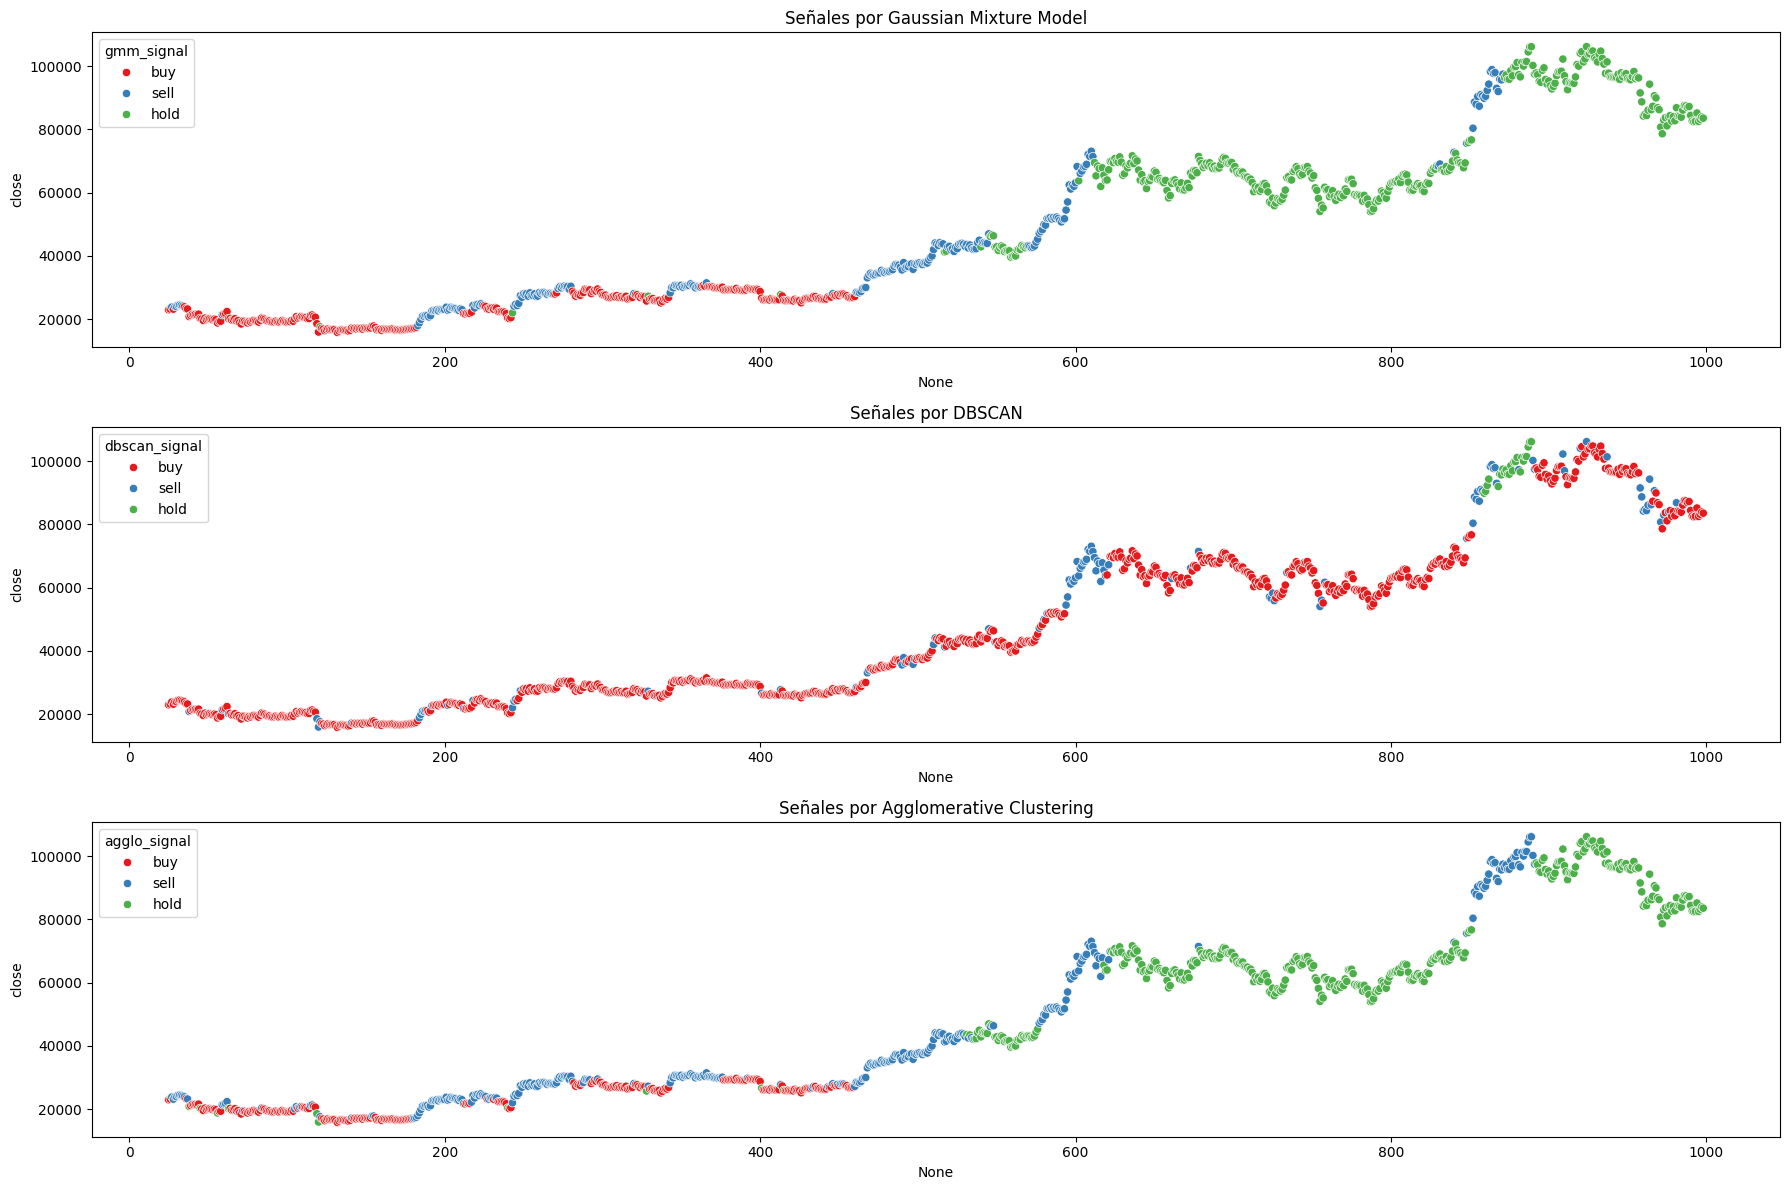

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que btc_full ya está cargado y contiene los indicadores técnicos
features = ['rsi', 'macd', 'adx', 'adp', 'adm', 'dri', 'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']
X = btc_full[features].dropna()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------------
# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=3, random_state=42)
btc_full.loc[X.index, 'gmm_cluster'] = gmm.fit_predict(X_scaled)

# ----------------------------------
# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
btc_full.loc[X.index, 'dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# ----------------------------------
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)
btc_full.loc[X.index, 'agglo_cluster'] = agglo.fit_predict(X_scaled)

# ----------------------------------
# Mapear clusters a señales para cada modelo
def map_clusters_to_signals(cluster_series):
    unique_clusters = cluster_series.dropna().unique()
    signal_map = {cluster: label for cluster, label in zip(unique_clusters, ['buy', 'sell', 'hold'])}
    return cluster_series.map(signal_map)

btc_full['gmm_signal'] = map_clusters_to_signals(btc_full['gmm_cluster'])
btc_full['dbscan_signal'] = map_clusters_to_signals(btc_full['dbscan_cluster'])
btc_full['agglo_signal'] = map_clusters_to_signals(btc_full['agglo_cluster'])

# ----------------------------------
# Visualización
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
sns.scatterplot(data=btc_full, x=btc_full.index, y='close', hue='gmm_signal', palette='Set1')
plt.title('Señales por Gaussian Mixture Model')

plt.subplot(3, 1, 2)
sns.scatterplot(data=btc_full, x=btc_full.index, y='close', hue='dbscan_signal', palette='Set1')
plt.title('Señales por DBSCAN')

plt.subplot(3, 1, 3)
sns.scatterplot(data=btc_full, x=btc_full.index, y='close', hue='agglo_signal', palette='Set1')
plt.title('Señales por Agglomerative Clustering')

plt.tight_layout()
plt.show()
